In [1]:
import h5py
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold._t_sne")

import time

import itertools
#import torch
#from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# import torch
# import torch.nn as nn
# import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, Dataset
#from torch.utils.data import DataLoader
#import numpy as np
#import itertools

import os
import pickle

In [2]:
file_path = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/natural_movies"
filename = "triplet_patches.mat"

## SK refactored
performed training via script, jump to testing

In [3]:
# Set file path and variable name (adjust as needed)
mat_path = file_path + "triplet_patches.mat"
#mat_path = file_path + "allPatches.mat"
mat_key = "allPatches"  # or whatever the key is in your .mat file

In [4]:
# Load from HDF5
with h5py.File(mat_path, 'r') as f:
    raw = f[mat_key]
    print("Raw HDF5 shape:", raw.shape)
    data = np.array(raw)  # this ensures a clean ndarray

# Transpose if necessary
if data.shape == (16, 16, 3, 50000):
    data = data.transpose(3, 2, 0, 1)  # -> (50000, 3, 16, 16)

# Convert to float32 Torch tensor
triplet_data = torch.tensor(data).float() / 255.0

# mean = triplet_data.mean(dim=(2, 3), keepdim=True)  # shape (N, C, 1, 1)
# std = triplet_data.std(dim=(2, 3), keepdim=True)    # shape (N, C, 1, 1)
# triplet_data = (triplet_data - mean) / (std + 1e-8)

print("Final triplet_data shape:", triplet_data.shape)

Raw HDF5 shape: (100000, 3, 16, 16)
Final triplet_data shape: torch.Size([100000, 3, 16, 16])


In [5]:
# Extract anchor, positive, and negative from the triplet tensor
anchor   = triplet_data[:, 0, :, :]
positive = triplet_data[:, 1, :, :]
negative = triplet_data[:, 2, :, :]

# Flatten images into vectors
a = anchor.view(anchor.size(0), -1)
p = positive.view(positive.size(0), -1)
n = negative.view(negative.size(0), -1)

# Compute distances
ap_dist = F.pairwise_distance(a, p)
an_dist = F.pairwise_distance(a, n)

# Compute margin violations
margin = 0.2
violations = (ap_dist + margin > an_dist).float()

# Compute stats
mean_ap = ap_dist.mean().item()
mean_an = an_dist.mean().item()
violation_rate = violations.mean().item()

# Print results
print("Triplet Margin Stats:")
print(f"  Mean anchor-positive distance: {mean_ap:.4f}")
print(f"  Mean anchor-negative distance: {mean_an:.4f}")
print(f"  % Triplets violating margin ({margin}): {violation_rate * 100:.2f}%")

Triplet Margin Stats:
  Mean anchor-positive distance: 3.3578
  Mean anchor-negative distance: 5.7631
  % Triplets violating margin (0.2): 14.40%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Assume triplet_data is a tensor of shape (N, 3, H, W)
# Convert to numpy if needed
X_np = triplet_data.numpy() if isinstance(triplet_data, torch.Tensor) else triplet_data

# Extract positives and negatives
positives = X_np[:, 1].reshape(X_np.shape[0], -1)  # shape: (N, H*W)
negatives = X_np[:, 2].reshape(X_np.shape[0], -1)

# Stack data and labels
X = np.vstack([positives, negatives])  # shape: (2N, H*W)
y = np.hstack([np.ones(len(positives)), np.zeros(len(negatives))])  # shape: (2N,)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)

print(f"🔍 Logistic Regression Accuracy: {acc:.4f}")
print(f"📈 ROC AUC Score: {auc:.4f}")

In [ ]:
def gini_index(x):
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0:
        raise ValueError("Gini index is only defined for non-negative values")
    if np.all(x == 0):
        return 0.0  # Convention: Gini is 0 for uniform zero vector

    x_sorted = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x_sorted) / np.sum(x)) / n - (n + 1) / n

In [ ]:
def compute_triplet_margin_stats(model, dataloader, device, margin=0.2):

    model.eval()
    ap_dists = []
    an_dists = []
    violations = []

    with torch.no_grad():
        for a, p, n in dataloader:
            a, p, n = a.to(device), p.to(device), n.to(device)

            anchor = model(a)
            positive = model(p)
            negative = model(n)

            ap = F.pairwise_distance(anchor, positive)
            an = F.pairwise_distance(anchor, negative)

            ap_dists.append(ap)
            an_dists.append(an)
            violations.append((ap + margin > an).float())

    ap_dists = torch.cat(ap_dists)
    an_dists = torch.cat(an_dists)
    violations = torch.cat(violations)

    mean_ap = ap_dists.mean().item()
    mean_an = an_dists.mean().item()
    violation_rate = violations.mean().item()

    return mean_ap, mean_an, violation_rate

In [ ]:
#from torch.utils.data import Dataset

class TripletDataset(Dataset):
    def __init__(self, triplet_tensor):
        self.triplets = triplet_tensor  # could be a Tensor or a Subset

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        anchor = triplet[0].unsqueeze(0)  # shape: (1, 16, 16)
        positive = triplet[1].unsqueeze(0)
        negative = triplet[2].unsqueeze(0)
        return anchor, positive, negative

In [ ]:


# Split into train / val / test
N = len(triplet_data)
train_size = int(0.7 * N)
val_size = int(0.1 * N)
test_size = N - train_size - val_size
train_data, val_data, test_data = random_split(triplet_data, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(TripletDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TripletDataset(val_data), batch_size=batch_size)
test_loader = DataLoader(TripletDataset(test_data), batch_size=batch_size)

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.fc = nn.Linear(16*16, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        out = self.relu(self.fc(x))  # Linear followed by ReLU
        return out

In [ ]:
def evaluate_loss(model, data_loader, criterion, device, l1_lambda=0.0):
    model.eval()
    total_loss = 0.0
    total_triplet = 0.0
    total_l1 = 0.0

    with torch.no_grad():
        for a, p, n in data_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_out, p_out, n_out = model(a), model(p), model(n)

            triplet_loss = criterion(a_out, p_out, n_out)

            l1_penalty = 0.0
            if l1_lambda > 0:
                l1_penalty = (
                    a_out.abs().sum() +
                    p_out.abs().sum() +
                    n_out.abs().sum()
                ) / a_out.shape[0]

            loss = triplet_loss + l1_lambda * l1_penalty

            total_loss += loss.item()
            total_triplet += triplet_loss.item()
            total_l1 += l1_penalty

    n_batches = len(data_loader)
    return (
        total_loss / n_batches,
        total_triplet / n_batches,
        total_l1 / n_batches
    )

In [ ]:
def gaussian_kernel2d(kernel_size=5, sigma=0.25, device='cpu'):
    ax = torch.arange(kernel_size, device=device) - kernel_size // 2
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

In [ ]:
def smooth_weights(model, sigma=0.25):
    # Get weights and reshape (embedding_dim, 256) -> (embedding_dim, 1, 16, 16)
    weight = model.fc.weight.data
    emb_dim = weight.shape[0]
    weight_reshaped = weight.view(emb_dim, 1, 16, 16)

    # Build Gaussian kernel
    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel2d(kernel_size, sigma, device=weight.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    # Convolve all embeddings in one pass (treat each as separate batch)
    smoothed = F.conv2d(weight_reshaped, kernel, padding=kernel_size // 2)

    # Flatten back and copy into model
    model.fc.weight.data.copy_(smoothed.view(emb_dim, -1))

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device, 
          embedding_dim, epochs=10, patience=5, min_delta=1e-4, l1_lambda=0.0,
         margin=0.2):

    model.to(device)
    
    train_losses, val_losses = [], []
    train_triplet_losses, val_triplet_losses = [], []
    train_l1_norms, val_l1_norms = [], []
    
    train_violations, val_violations = [], []
    
    
    best_val_loss = float('inf')
    best_state = None
    best_epoch = 0
    wait = 0
    start_time = time.time()

    # ---- Initial evaluation before training ----
    train_loss, train_triplet_loss, train_l1_norm = evaluate_loss(model, train_loader,
                                                            criterion, device)
    train_losses.append(train_loss)
    train_triplet_losses.append(train_triplet_loss)
    train_l1_norms.append(train_l1_norm)
    
    _, _, v_train = compute_triplet_margin_stats(model, train_loader, device)
    train_violations.append(v_train)

    val_loss, val_triplet_loss, val_l1_norm = evaluate_loss(model, val_loader,
                                                            criterion, device)
    val_losses.append(val_loss)
    val_triplet_losses.append(val_triplet_loss)
    val_l1_norms.append(val_l1_norm)
    
    _, _, v_val = compute_triplet_margin_stats(model, val_loader, device)
    val_violations.append(v_val)

    best_val_loss = val_losses[-1]
    best_state = model.state_dict()

    # ---- Training loop ----
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_triplet = 0.0
        total_l1 = 0.0
        
        for a, p, n in train_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            a_out, p_out, n_out = model(a), model(p), model(n)
            triplet_loss = criterion(a_out, p_out, n_out)

            l1_penalty = 0.0
            if l1_lambda > 0:
                l1_penalty = (
                    a_out.abs().sum() +
                    p_out.abs().sum() +
                    n_out.abs().sum()
                ) / a_out.shape[0]

            loss = triplet_loss + l1_lambda * l1_penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_triplet += triplet_loss.item()
            total_l1 += l1_penalty

        
            
        train_losses.append(total_loss / len(train_loader))
        train_triplet_losses.append(total_triplet / len(train_loader))
        train_l1_norms.append(total_l1 / len(train_loader))
        
        smooth_weights(model, sigma=0.25)
        
        # compute violations
        _, _, v_train = compute_triplet_margin_stats(model, train_loader, device)
        train_violations.append(v_train)

        val_loss, val_triplet_loss, val_l1_norm = evaluate_loss(model, val_loader, criterion, device, l1_lambda)
        val_losses.append(val_loss)
        val_triplet_losses.append(val_triplet_loss)
        val_l1_norms.append(val_l1_norm)
        _, _, v_val = compute_triplet_margin_stats(model, val_loader, device)
        val_violations.append(v_val)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_state = model.state_dict()
            best_epoch = epoch + 1
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n Early stopping at epoch {epoch + 1}")
                break

        print('.', end='', flush=True)
        if (epoch + 1) % 10 == 0:
            print(f' Epoch {epoch + 1}')

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    model.load_state_dict(best_state)


        
    # Save model state separately
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_path = f"{model_path}/class_triplet_patches_M{margin_str}_ED{embedding_dim}_EP{epochs}.pt"
    torch.save(model.state_dict(), model_path)

    # Save metadata separately
    meta_path = f"{model_path}/class_triplet_patches_M{margin_str}_ED{embedding_dim}_EP{epochs}.pkl"
    with open(meta_path, 'wb') as f:
        pickle.dump({
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_triplet_losses": train_triplet_losses,
            "val_triplet_losses": val_triplet_losses,
            "train_l1_norms": train_l1_norms,
            "val_l1_norms": val_l1_norms,
            "train_viol": train_violations,
            "val_viol": val_violations,
            "train_time": total_time,
            "best_epoch": best_epoch
        }, f)

    return model

In [ ]:
4096*8


In [ ]:
# Fixed hyperparameters
epochs = 200
patience = 5
min_delta = 1e-4

# --- Hyperparameter grid ---
learning_rate = [1e-4]
weight_decays = [0]
batch_sizes = [64]

l1_lambdas = [0]
# embedding_dims = [8, 16, 32, 64, 128, 256, 512]
# margins = [0.1, 0.2, 0.3, 0.4]

# embedding_dims = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
# margins = [0.25, 0.5, 1., 2., 4.]

embedding_dims = [4, 8, 16384, 32768]
margins = [1.]

hyper_params = []
model_id = 0


for lr, wd, bs, ed, ll, mm in itertools.product(learning_rate, weight_decays, batch_sizes,\
                                            embedding_dims, l1_lambdas, margins):
    hyper_params.append({
        "model id": model_id,
        "learning rate": lr,
        "weight decay": wd,
        "batch size": bs,
        "embedding dim": ed,
        "l1 lambda": ll,
        "margin": mm,
        "epochs": epochs,
        "patience": patience,
        "min delta": min_delta,
    })

    
n_models = len(hyper_params)
print(n_models)

In [ ]:
for model_id in range(n_models):
    lr = hyper_params[model_id]["learning rate"]
    wd = hyper_params[model_id]["weight decay"]
    bs = hyper_params[model_id]["batch size"]
    ed = hyper_params[model_id]["embedding dim"]
    ll = hyper_params[model_id]["l1 lambda"]
    epochs = hyper_params[model_id]["epochs"]
    margin = hyper_params[model_id]["margin"]
    patience = hyper_params[model_id]["patience"]
    min_delta = hyper_params[model_id]["min delta"]
    #lambda_str = "0" if ll == 0 else f"{ll:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    hyper_path = f"{model_path}/class_triplet_patches_hyper_M{margin_str}_ED{ed}_EP{epochs}.pkl"
    with open(hyper_path, 'wb') as f:
        pickle.dump({
        "model id": model_id,
        "learning rate": lr,
        "weight decay": wd,
        "batch size": bs,
        "embedding dim": ed,
        "l1 lambda": ll,
        "epochs": epochs,
        "margin": margin,
        "patience": patience,
        "min delta": min_delta,
        }, f)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Iterate over all combinations ---
for model_id in range(n_models):
    learning_rate = hyper_params[model_id]["learning rate"]
    wd = hyper_params[model_id]["weight decay"]
    bs = hyper_params[model_id]["batch size"]
    ed = hyper_params[model_id]["embedding dim"]
    ll = hyper_params[model_id]["l1 lambda"]
    epochs = hyper_params[model_id]["epochs"]
    margin = hyper_params[model_id]["margin"]
    patience = hyper_params[model_id]["patience"]
    min_delta = hyper_params[model_id]["min delta"]
    
    #lambda_str = "0" if ll == 0 else f"{ll:.0e}".replace('-', 'm')
    #margin_str = f"{margin:.1f}".replace('.', 'p')
    print(f"\nTraining {model_id+1}/{n_models} with M={margin}, ED={ed}, WD={wd}, BS={bs}")
    # Dataloaders
    train_loader = DataLoader(TripletDataset(train_data), batch_size=bs, shuffle=True)
    val_loader = DataLoader(TripletDataset(val_data), batch_size=bs)

    model = EmbeddingNet(embedding_dim=ed)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    criterion = nn.TripletMarginLoss(margin=margin)

    model = train(model,train_loader,val_loader,
                    optimizer,criterion,device,
                    embedding_dim=ed, epochs=epochs,patience=patience,
                      min_delta=min_delta, l1_lambda=ll,margin=margin)

print(f"Grid completed")

## Testing
testing starts here

In [3]:
import sys
sys.path.append("..")

from utils import Utils as u
from train import TripletDataset

#from tqdm import tqdm

In [4]:
model_path = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies"

In [5]:
# Fixed hyperparameters
epochs = 200
patience = 5
min_delta = 1e-4

# --- Hyperparameter grid ---
learning_rate = [1e-4]
weight_decays = [0]
batch_sizes = [64]

l1_lambdas = [0]
# embedding_dims = [8, 16, 32, 64, 128, 256, 512]
# margins = [0.1, 0.2, 0.3, 0.4]

embedding_dims = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
margins = [3., 4., 5.]

# embedding_dims = [4, 8, 16384, 32768]
# margins = [1.]

hyper_params = []
model_id = 0


for lr, wd, bs, ed, ll, mm in itertools.product(learning_rate, weight_decays, batch_sizes,\
                                            embedding_dims, l1_lambdas, margins):
    hyper_params.append({
        "model id": model_id,
        "learning rate": lr,
        "weight decay": wd,
        "batch size": bs,
        "embedding dim": ed,
        "l1 lambda": ll,
        "margin": mm,
        "epochs": epochs,
        "patience": patience,
        "min delta": min_delta,
    })

    
n_models = len(hyper_params)
print(n_models)

30


In [6]:
results = []

for hp in hyper_params:  # assuming hyper_params is a list of dicts with 'hidden dim' and 'embedding dim'
    embedding_dim = hp['embedding dim']
    margin = hp['margin']
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    margin_str = f"{margin:.1f}".replace('.', 'p')
    filename = f"{model_path}/class_triplet_patches_meta_M{margin_str}_V1{embedding_dim}_EP{epochs}.pkl"
    if not os.path.exists(filename):
        print(f" File not found: {filename}")
        continue

    with open(filename, 'rb') as f:
        print(filename)
        saved = pickle.load(f)

    results.append({
        "train_losses": saved["train_losses"],
        "val_losses": saved["val_losses"],
        "train_viol": saved["train_viol"],
        "val_viol": saved["val_viol"],
        "train_time": saved["train_time"],
        "best_epoch": saved["best_epoch"],        
    })

print(f" Loaded {len(results)} models from disk")

/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M3p0_V132_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M4p0_V132_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M5p0_V132_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M3p0_V164_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M4p0_V164_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M5p0_V164_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M3p0_V1128_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalam

/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M5p0_V1128_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M3p0_V1256_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M4p0_V1256_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M5p0_V1256_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M3p0_V1512_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M4p0_V1512_EP200.pkl
/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models/natural_movies/class_triplet_patches_meta_M5p0_V1512_EP200.pkl
/u/home/s/skirti/project-mdipoppa/

In [7]:
# --- Sort and pick best based on early stopping ---
best_id = min(range(len(results)), key=lambda i: min(results[i]["val_losses"]))
best_result = results[best_id]
best_hyperparams = hyper_params[best_id]
best_val_loss = min(best_result["val_losses"])

print("\n Best config:")
print(f"   ED={best_hyperparams['embedding dim']}, "
    f"M={best_hyperparams['margin']}")
print(f"   Best Validation Loss={best_val_loss:.4f}")
print(f"   Training Time: {best_result['train_time']:.2f} sec")


 Best config:
   ED=1024, M=3.0
   Best Validation Loss=0.8702
   Training Time: 1447.52 sec


In [8]:
def extract_output_activations(model, model_file, test_loader, device):

    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()

    out_acts = []

    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            out_anchor = model(anchor)
            out_positive = model(positive)
            out_negative = model(negative)

            out_batch = torch.stack([out_anchor, out_positive, out_negative], dim=1)
            out_acts.append(out_batch.cpu())

    out_acts = torch.cat(out_acts, dim=0).numpy()
    return out_acts

In [9]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.fc = nn.Linear(16*16, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        out = self.relu(self.fc(x))  # Linear followed by ReLU
        return out

In [10]:
# load the data
triplet_data, labels = u.load_mat(
    filepath="/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/natural_movies/triplet_patches.mat",
    data_key="allPatches",
    v7=False
)

np.random.seed(1234)
triplets = torch.Tensor(triplet_data.numpy().transpose(2, 3, 0, 1))
indices = np.random.permutation(len(triplets))
train_size, val_size = int(0.7 * len(triplets)), int(0.1 * len(triplets))
train_loader = DataLoader(TripletDataset(triplets[indices[:train_size]]))
val_loader = DataLoader(TripletDataset(triplets[indices[train_size:train_size + val_size]]))
test_loader = DataLoader(TripletDataset(triplets[indices[train_size + val_size:]]))

torch.float32 torch.float32 torch.float32


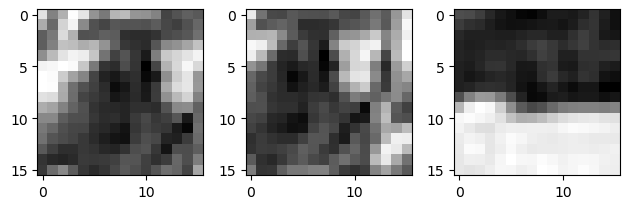

In [15]:
for a,p,n in train_loader:
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(a.reshape(16,16), cmap="gray")
    ax[1].imshow(p.reshape(16,16), cmap="gray")
    ax[2].imshow(n.reshape(16,16), cmap="gray")
    print(a.dtype, p.dtype, n.dtype)
    breakx
    
fig.set_tight_layout(True)
plt.show()

In [11]:
n_test = 20000
test_results = []
device = "cuda" if torch.cuda.is_available() else "cpu"

for model_id in range(n_models):
    ed = hyper_params[model_id]["embedding dim"]
    margin = hyper_params[model_id]["margin"]
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_file = f"{model_path}/class_triplet_patches_weights_M{margin_str}_V1{ed}_EP{epochs}.pt"
    print(f"M{margin_str}, ED{ed}, EP{epochs}")
    if not os.path.exists(model_file):
        print(f" Missing files for ED={ed}")
        continue

    model = EmbeddingNet(embedding_dim=ed)
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()
    
    criterion = nn.TripletMarginLoss(margin=margin)
    # --- Compute test loss using evaluate_loss ---
    test_loss, test_triplet_loss, test_l1_norm = u.evaluate_loss(model, test_loader,
                                                                  criterion, device)

    # --- Compute margin violation percentage on test set ---
    _, _, test_violation_pct = u.compute_triplet_margin_stats(model, test_loader,
                                                            device, margin=0.2)

    # Compute Gini index
    out_acts = extract_output_activations(model=model,model_file=model_file,
        test_loader=test_loader,device=device)
    #print("Hidden activations shape:", out_acts.shape)
        
    gini_act = np.zeros((n_test,3))
    for i in range(n_test):
        for j in range(3):
            adj = np.where(out_acts[i,j,:] < 0, 0, out_acts[i,j,:])
            #print(np.amin(adj) < 0)
            gini_act[i,j] = u.gini(adj)
    gini_act_m = np.mean(gini_act)
    
    test_results.append({
        "test_losses": test_loss,
        "test_triplet_loss": test_triplet_loss,
        "test_l1_norm": test_l1_norm,
        "test_viol": test_violation_pct,
        "test_gini": gini_act_m,
    })
    
    test_path = f"{model_path}/class_triplet_patches_test_M{margin_str}_ED{ed}_EP{epochs}.pkl"
    with open(test_path, 'wb') as f:
        pickle.dump({
        "test_loss": test_loss,
        "test_triplet_loss": test_triplet_loss,
        "test_l1_norm": test_l1_norm,
        "test_viol": test_violation_pct,
        "test_gini": gini_act_m,
        }, f)


M3p0, ED32, EP200
M4p0, ED32, EP200
M5p0, ED32, EP200
M3p0, ED64, EP200
M4p0, ED64, EP200
M5p0, ED64, EP200
M3p0, ED128, EP200
M4p0, ED128, EP200
M5p0, ED128, EP200
M3p0, ED256, EP200
M4p0, ED256, EP200
M5p0, ED256, EP200
M3p0, ED512, EP200
M4p0, ED512, EP200
M5p0, ED512, EP200
M3p0, ED1024, EP200
M4p0, ED1024, EP200
M5p0, ED1024, EP200
M3p0, ED2048, EP200
M4p0, ED2048, EP200
M5p0, ED2048, EP200
M3p0, ED4096, EP200
M4p0, ED4096, EP200
M5p0, ED4096, EP200
M3p0, ED8192, EP200
M4p0, ED8192, EP200
M5p0, ED8192, EP200
M3p0, ED16384, EP200
M4p0, ED16384, EP200
M5p0, ED16384, EP200


In [13]:
def format_param(val):
    if val == 0:
        return "0"
    elif val < 1:
        return f"{val:.0e}"
    else:
        return str(val)

In [14]:
print(min(result['best_epoch']  for result in results))
print(max(result['best_epoch']  for result in results))

0
0


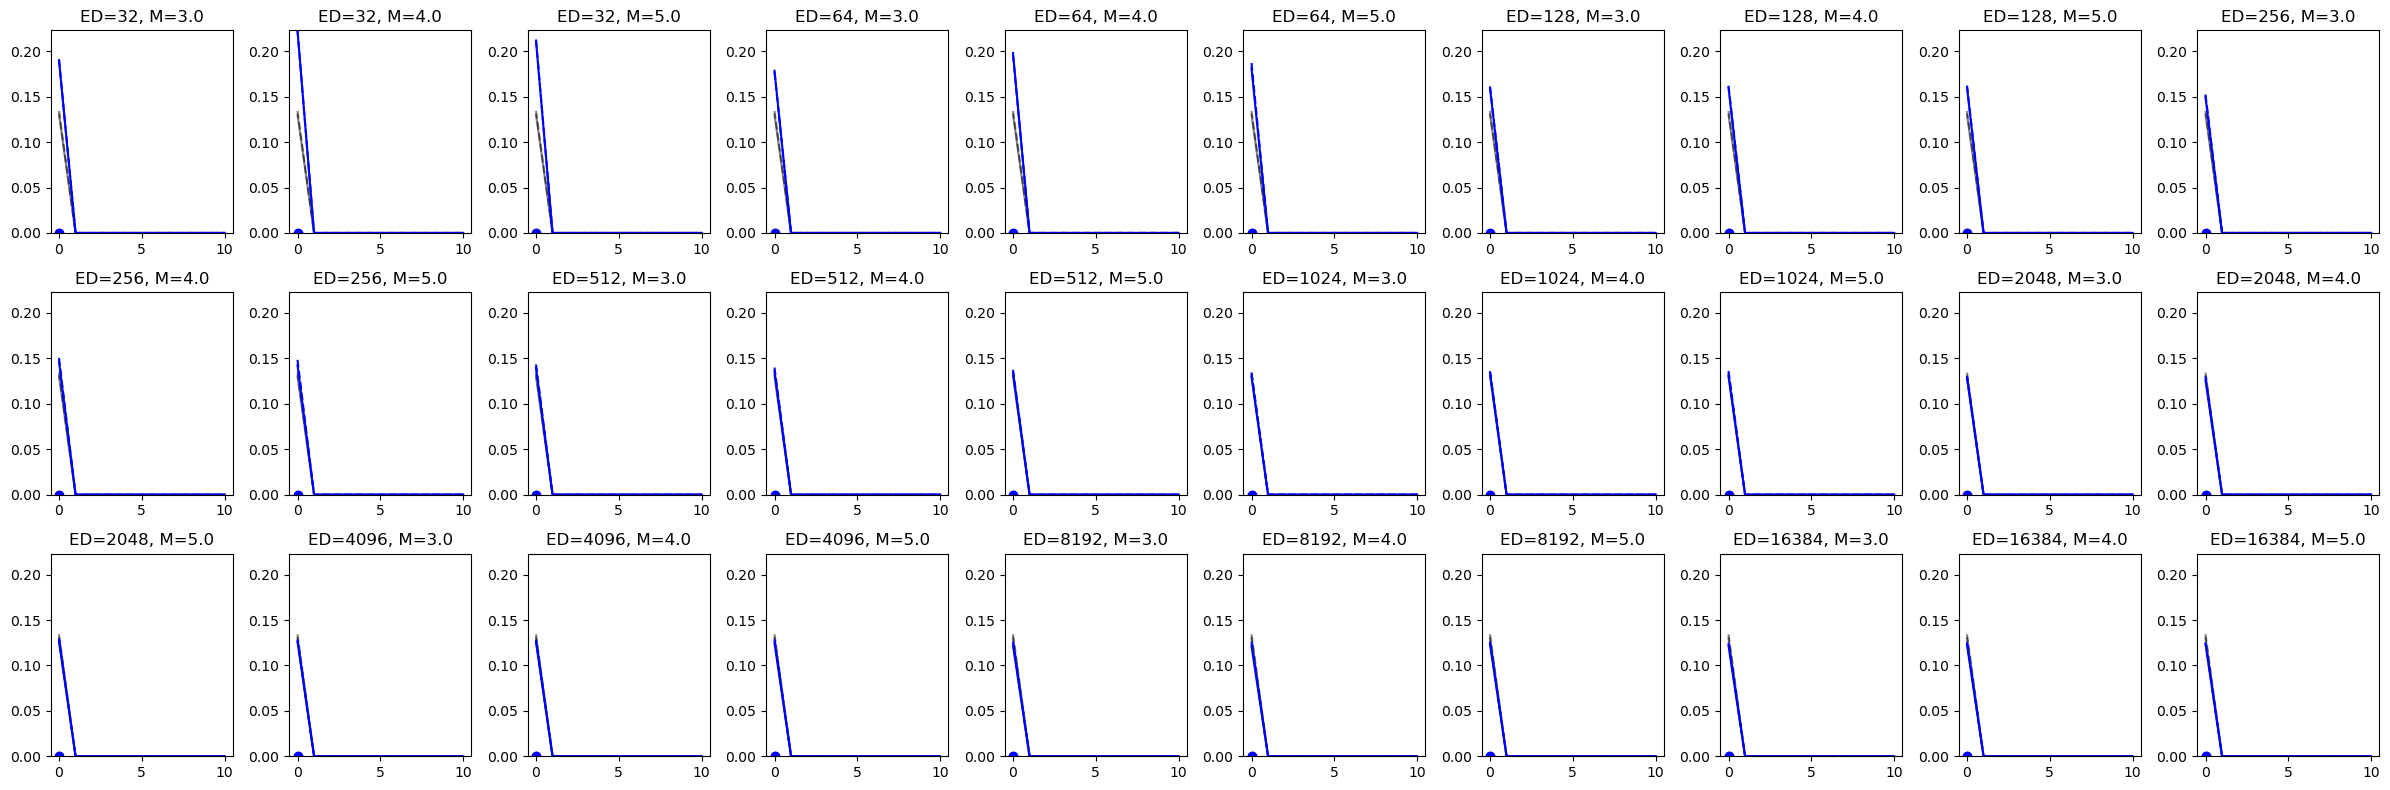

In [18]:
metric = "losses"
metric = "viol"

min_loss = min(min(r["train_"+metric] + r["val_"+metric]) for r in results)
max_loss = max(max(r["train_"+metric] + r["val_"+metric]) for r in results)

plt.figure(figsize=(24,8))
ip = 0
for model_id in range(len(hyper_params)):
    ip += 1
    plt.subplot(3,10,ip)
    mm = hyper_params[model_id]["margin"]
    ed = hyper_params[model_id]["embedding dim"]

    
    hyper_p = f"ED={format_param(ed)}, M={format_param(mm)}"
    

    plt.plot(results[best_id]['train_'+metric],'k--',alpha=0.5)
    plt.plot(results[best_id]['val_'+metric],'k-',alpha=0.5)
    plt.plot(results[best_id]['best_epoch'],test_results[best_id]['test_'+metric],'ko',alpha=0.5)

    plt.plot(results[model_id]['train_'+metric],'b--')
    plt.plot(results[model_id]['val_'+metric],'b-')
    plt.plot(results[model_id]['best_epoch'],test_results[model_id]['test_'+metric],'bo')
    plt.ylim(min_loss,max_loss)
    plt.title(hyper_p)
    #plt.yscale('log')
    plt.tight_layout()

/tmp/ipykernel_32184/493724105.py:34: RuntimeWarning: invalid value encountered in divide
  test_losses /= test_losses[0]


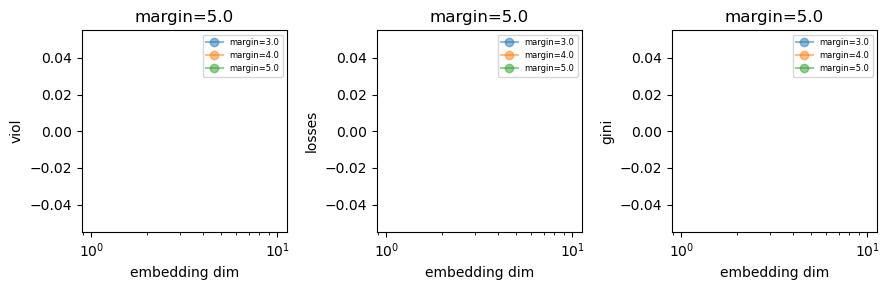

In [19]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"

xvar = 'embedding dim'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(9, 3))
ip = 0
for metric in metric_i:
    ip += 1
    plt.subplot(1,3,ip)
    
    xval_array = np.array(xvals)

    for yval in yvals:
        

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(test_results[model_id]['test_'+metric])
        test_losses = np.array(test_losses)
        test_losses /= test_losses[0]
        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        # Formatting
        plt.xscale("log")
        plt.xlabel(xvar)
        plt.ylabel(metric)
        plt.title(label)
        plt.legend(fontsize=6)
        plt.tight_layout()

In [ ]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'embedding dim'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(12, 6))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in [4.0]:
        ip += 1
        plt.subplot(3,5,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(test_results[model_id]['test_'+metric])

        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        #plt.plot(human_exp*np.ones(2), yl, '-.g', linewidth=2)  # vertical line at x=7
        # Formatting
        plt.xscale("log")
        plt.xlabel("Embedding dimension")
        if metric == "viol":
            plt.ylabel("Fraction violations")
        elif metric == "losses":
            plt.ylabel("Triplet loss")
        elif metric == "gini":
            plt.ylabel("Gini index")

        
        #plt.title(label)
        #plt.legend()
        plt.tight_layout()
plt.savefig('figures/test_results_margin4.pdf')

In [ ]:
mouse_exp

In [ ]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'embedding dim'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(9, 6))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in yvals:
        ip += 1
        plt.subplot(3,5,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(test_results[model_id]['test_'+metric])

        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        #plt.plot(human_exp*np.ones(2), yl, '-.g', linewidth=2)  # vertical line at x=7
        # Formatting
        plt.xscale("log")
        plt.xlabel(xvar)
        plt.ylabel(metric)
        plt.title(label)
        #plt.legend()
        plt.tight_layout()
plt.savefig('figures/test_results.png')

In [ ]:
def rearrange_blocks_fixed(blocks, p, q):
    m, n1, n2 = blocks.shape
    assert n1 == n2, "Blocks must be square"
    assert m == p * q, "m must equal p * q"
    n = n1
    reshaped = blocks.reshape(p, q, n, n)
    merged = reshaped.swapaxes(1, 2).reshape(p * n, q * n)
    return merged

In [ ]:
def resmooth_weights(model, sigma=0.25):
    weight = model.fc.weight.data
    emb_dim = weight.shape[0]
    weight_reshaped = weight.view(emb_dim, 1, 16, 16)

    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel2d(kernel_size, sigma, device=weight.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    smoothed = F.conv2d(weight_reshaped, kernel, padding=kernel_size // 2)
    model.fc.weight.data.copy_(smoothed.view(emb_dim, -1))

In [ ]:
# Load best model
weights_reshaped = []
for model_id in range(n_models):

    ed = hyper_params[model_id]["embedding dim"]

    margin = hyper_params[model_id]["margin"]
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_file = f"{model_path}/class_triplet_patches_M{margin_str}_ED{ed}_EP{epochs}.pt"
    model = EmbeddingNet(embedding_dim=ed)
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()

    # ---- Smooth the weights again ----
    resmooth_weights(model, sigma=1.)

    # Extract weights from first layer (input to hidden): shape (n_hidden_units, 256)
    first_layer = model.fc  # Replace if you used a different name
    weights = first_layer.weight.detach().cpu().numpy()  # shape: (n_hidden_units, 256)

    # Reshape to (n_hidden_units, 16, 16)
    weights_reshaped.append(weights.reshape(weights.shape[0], 16, 16))

    #print("Weight shape:", weights_reshaped[model_id].shape)  # (n_hidden_units, 16, 16)

In [ ]:


n = 16
p = 4 # rows 
q = 8 # columns
size_factor = 0.5
for model_id in range(n_models):
    
    embedding_dim = hyper_params[model_id]['embedding dim']
    margin = hyper_params[model_id]['margin']
    # ---- Filter ----
    if margin != 4.0 or embedding_dim not in [32, 512, 4096]:
        continue  # skip models that don't match criteria
    
    merged_rf = rearrange_blocks_fixed(weights_reshaped[model_id][:32,:,:], p=p, q=q)
    plt.figure(figsize=(q*size_factor,p*size_factor))
    plt.imshow(merged_rf)
    for i in range(q+1):
        plt.plot(i*n*np.ones(2)-0.5,np.array([0,n*p])-0.5,'w')
    for i in range(p+1):
        plt.plot(np.array([0,n*q])-0.5,i*n*np.ones(2)-0.5,'w')
    plt.xticks([])
    plt.yticks([])
    embedding_dim = hyper_params[model_id]['embedding dim']
    margin = hyper_params[model_id]['margin']
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    plt.title(f"M={margin}, ED={embedding_dim}")
    
    plt.tight_layout()
    plt.savefig(f'figures/RF_ED{embedding_dim}.pdf')